C:\Users\dasar\AppData\Local\Temp\ipykernel_8912\1005383084.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)
c:\Users\dasar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (lstm): LSTM(2, 64, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


c:\Users\dasar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\dasar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Loss: 0.3080, Time: 0.12s
Epoch [11/100], Loss: 0.0779, Time: 0.06s
Epoch [21/100], Loss: 0.0761, Time: 0.09s
Epoch [31/100], Loss: 0.0756, Time: 0.06s
Epoch [41/100], Loss: 0.0727, Time: 0.06s
Epoch [51/100], Loss: 0.0756, Time: 0.06s
Epoch [61/100], Loss: 0.0738, Time: 0.09s
Epoch [71/100], Loss: 0.0756, Time: 0.07s
Epoch [81/100], Loss: 0.0758, Time: 0.07s
Epoch [91/100], Loss: 0.0750, Time: 0.10s
RMSE: 0.1861


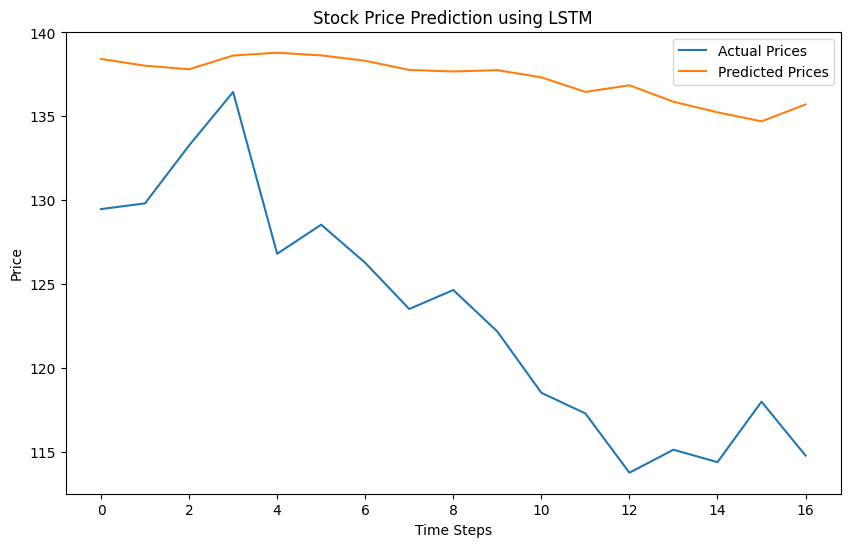

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import time

# Step 1: Load and preprocess the dataset
data = pd.read_csv("AMZN_dataset.csv")
series = data[['Close', 'sentiment_score']].values
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Step 2: Split the data into training and testing sets
train_size = int(len(series_scaled) * 0.8)
train_data, test_data = series_scaled[:train_size], series_scaled[train_size:]

# Step 3: Create sequences
def create_seq(series, seq_len):
    xs, ys = [], []
    for i in range(len(series) - seq_len):
        x = series[i:i + seq_len]
        y = series[i + seq_len, 0]  # Predicting 'Close' prices only
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

seq_len = 30
x_train, y_train = create_seq(train_data, seq_len)
x_test, y_test = create_seq(test_data, seq_len)

# Step 4: Create DataLoader for batching
batch_size = 8
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

# Step 5: Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

input_dim = 2
hidden_dim = 64
output_dim = 1
num_layers = 1
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
print(model)

# Step 6: Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Step 7: Train the LSTM model
def train_model(model, train_loader, num_epochs=150):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')

train_model(model, train_loader, num_epochs=100)

# Step 8: Make predictions
model.eval()
with torch.no_grad():
    predictions = model(x_test)

# Add a second column of zeros to match the scaler's expected input shape
prediction_t = scaler.inverse_transform(
    np.concatenate((predictions.detach().numpy(), np.zeros((predictions.shape[0], 1))), axis=1)
)[:, 0]

# Inverse transform y_test without padding, since it contains only closing prices
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test_np.reshape(-1, 1), np.zeros((y_test_np.shape[0], 1))), axis=1)
)[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Prices')
plt.plot(prediction_t, label='Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()
